### 1.11.5 Histogram-Based Gradient Boosting

Scikit-learn has two implementations of histogram-based gradient boosters:
* `HistGradientBoostingClassifier`
* `HistGradientBoostingRegressor`

Histogram-based estimators can be **orders of magnitude** faster than other boosting classifiers, when the number of samples is larger than tens of thousands.

###### Example - Partial Dependence and Individual Conditional Expectation Plots
https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html#sphx-glr-auto-examples-inspection-plot-partial-dependence-py

#### 1.11.5.1 Usage

Most parameters are same as `GradientBoostingClassifier` and `GradientBoostingRegressor` except `max_iter` parameter replaces `n_estimators`, controlling the number of iterations

In [1]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.datasets import make_hastie_10_2

In [2]:
X, y = make_hastie_10_2(random_state=0)

X_train, X_test = X[:2000], X[2000:]
y_train, y_test = y[:2000], y[2000:]

In [3]:
clf = HistGradientBoostingClassifier(max_iter=100).fit(X_train, y_train)

clf.score(X_test, y_test)

0.8965

For histogram-gradient boosting algorithms, the number of bins used to bin the data is controlled by the `max_bins` parameter. It's generally recommended to use as many bins as possible, which is also the default setting

Note: **early stopping is enabled by default if number of samples is greater than 10,000**

#### 1.11.5.2 Missing values support
The histogram gradient boosting algorithms have built-in support for missing values (NaNs). During training, the tree grower learns at each split point whether samples with missing values should go left or rightt based on the potential gain

Example:

In [2]:
from sklearn.ensemble import HistGradientBoostingClassifier
import numpy as np

In [3]:
X = np.array([0,1,2,np.nan]).reshape(-1,1)
y = [0,0,1,1]

gbdt = HistGradientBoostingClassifier(min_samples_leaf=1).fit(X,y)
gbdt.predict(X)

array([0, 0, 1, 1])

When the missingness pattern is predictive, the splits can be done on whether the feature value is missing or not:

In [4]:
X = np.array([0,1,2,np.nan]).reshape(-1,1)
y = [0,0,1,1]

gbdt = HistGradientBoostingClassifier(min_samples_leaf=1, max_depth=2,
                                     learning_rate=1, max_iter=1)

gbdt.fit(X,y)
gbdt.predict(X)

array([0, 0, 1, 1])

#### 1.11.5.3 Sample weight support

The histogram-gradient boosting algorithms support weights during fit.

Example:

In [5]:
X = [[1,0],[1,0],[1,0],[0,1]]
y = [0,0,1,0]

#ignore the first 2 training samples by setting the weights to 0
sample_weight = [0,0,1,1]

In [6]:
gb = HistGradientBoostingClassifier(min_samples_leaf=1)
gb.fit(X, y, sample_weight=sample_weight)

HistGradientBoostingClassifier(min_samples_leaf=1)

In [7]:
gb.predict([[1,0]])

array([1])

In [9]:
gb.predict_proba([[1,0]])[0,1]

0.9990209190235209

So in this example, `[1,0]` is classified as `1` since the first two samples are ignored. Also note that the binning stage does not take weights into account.

#### 1.11.5.4 Categorical Features Support

The Hist-GB alogirthms have native support for categorical features, meaning they can consider splits on non-ordered categorical data.

Using the native categorical support is often better than relying on one-hot-encoding, which requires more tree depth to achieve equivalent splits. It's also better to use native categorical support rather than treating categorical features as continuous or ordinal, since categories are nominal quantities where order does not matter.

You enable categorical support by passing a boolean mask to the `categorical_features` parameter:

In [10]:
gbdt = HistGradientBoostingClassifier(categorical_features=[True,False])

In [11]:
gbdt = HistGradientBoostingClassifier(categorical_features=[0])

###### Example - Categorical Feature Support in Gradient Boosting

https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_categorical.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-categorical-py

#### 1.11.5.5 Monotonic Constraints

This is for when you have prior knowledge that a given feature should (in general) have a positive or negative effect on the target value. Specify using the `monotonic_cst` parameter:

In [12]:
gbdt = HistGradientBoostingClassifier(monotonic_cst=[1,-1,0])

###### Example - Monotonic Constraints

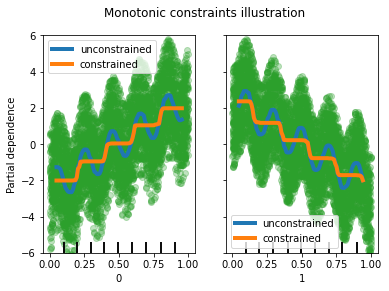

In [13]:
#COPYPASTA

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import PartialDependenceDisplay
import numpy as np
import matplotlib.pyplot as plt


rng = np.random.RandomState(0)

n_samples = 5000
f_0 = rng.rand(n_samples)  # positive correlation with y
f_1 = rng.rand(n_samples)  # negative correlation with y
X = np.c_[f_0, f_1]
noise = rng.normal(loc=0.0, scale=0.01, size=n_samples)
y = 5 * f_0 + np.sin(10 * np.pi * f_0) - 5 * f_1 - np.cos(10 * np.pi * f_1) + noise

fig, ax = plt.subplots()


# Without any constraint
gbdt = HistGradientBoostingRegressor()
gbdt.fit(X, y)
disp = PartialDependenceDisplay.from_estimator(
    gbdt,
    X,
    features=[0, 1],
    line_kw={"linewidth": 4, "label": "unconstrained", "color": "tab:blue"},
    ax=ax,
)

# With positive and negative constraints
gbdt = HistGradientBoostingRegressor(monotonic_cst=[1, -1])
gbdt.fit(X, y)

PartialDependenceDisplay.from_estimator(
    gbdt,
    X,
    features=[0, 1],
    feature_names=(
        "First feature\nPositive constraint",
        "Second feature\nNegtive constraint",
    ),
    line_kw={"linewidth": 4, "label": "constrained", "color": "tab:orange"},
    ax=disp.axes_,
)

for f_idx in (0, 1):
    disp.axes_[0, f_idx].plot(
        X[:, f_idx], y, "o", alpha=0.3, zorder=-1, color="tab:green"
    )
    disp.axes_[0, f_idx].set_ylim(-6, 6)

plt.legend()
fig.suptitle("Monotonic constraints illustration")

plt.show()

#### 1.11.5.6 Low-level parallelism

Scikit-learn implementations use OpenMP for parallelization through Cython.

The following parts are parallelized:
* mapping samples from real values to integer-valued bins
* building histograms is parallelized over features
* finding the best split point is parallelized over features
* during fit, mapping samples into the left and right children is parallelized over samples
* gradient and hessians computations are parallelized over samples
* prediciting is parallelized over samples

#### 1.11.5.7 Why it's faster

The bottleneck for gradient boosting is the actual building of decision trees, which normally require sorting the samples at each node for each feature (this is so the potential gain of a split point can be computed efficiently).

The histogram-gradient boosters do not require sorting the feature values and instead use a data structure called a histogram, where the samples are implicitly ordered.


### 1.11.6 Voting Classifier

The idea behind the `VotingClassifier` algorithm is to combine conceptually different ML classifiers and use a majority vote or average predicted probabilities (soft vote) to predict the class labels.

#### 1.11.6.1 Majority Class Labels (Majority/Hard Voting)

In majority voting, the predicted class label represents the majority (mode) of the class labels predicted by each individual classifier.

#### 1.11.6.2 Usage
Example:

In [14]:
from sklearn import datasets
from sklearn. model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [15]:
iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

In [16]:
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],
                        voting='hard')

In [20]:
for clf, label in zip([clf1,clf2,clf3,eclf],['LogReg','RandomForest',"GNB",'ensemble']):
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
    print(f"Accuracy: {scores.mean()} (+/-{scores.std()}) {label}")

Accuracy: 0.9533333333333334 (+/-0.039999999999999994) LogReg
Accuracy: 0.9400000000000001 (+/-0.038873012632301994) RandomForest
Accuracy: 0.9133333333333334 (+/-0.039999999999999994) GNB
Accuracy: 0.9533333333333334 (+/-0.039999999999999994) ensemble


#### 1.11.6.3 Weighted Average Probabilities (soft voting)

Soft voting returns the class label as argmax of the sum of predicted probabilities

Specific weights can be assigned to each classifer using the `weights` parameter

###### Example - Plot the decision boundaries of a VotingClassifier

In [21]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

In [24]:
#load sample data
iris = datasets.load_iris()

X = iris.data[:, [0,2]]
y = iris.target

In [25]:
#train classifiers

clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(gamma=0.1, kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)],
                       voting='soft', weights=[2,1,2])

clf1.fit(X,y)
clf2.fit(X,y)
clf3.fit(X,y)
eclf.fit(X,y)

VotingClassifier(estimators=[('dt', DecisionTreeClassifier(max_depth=4)),
                             ('knn', KNeighborsClassifier(n_neighbors=7)),
                             ('svc', SVC(gamma=0.1, probability=True))],
                 voting='soft', weights=[2, 1, 2])

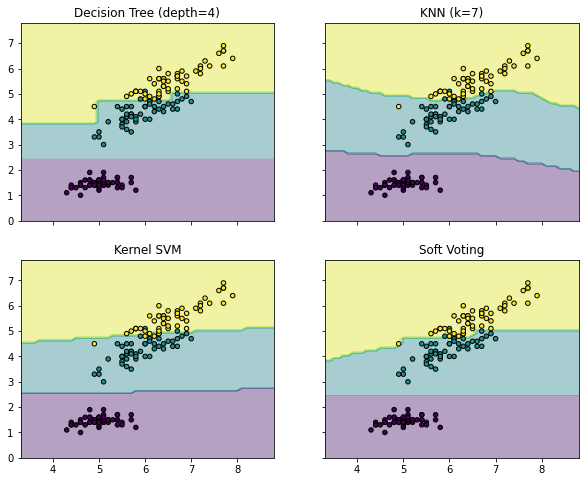

In [26]:
#COPYPASTA
# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex="col", sharey="row", figsize=(10, 8))

for idx, clf, tt in zip(
    product([0, 1], [0, 1]),
    [clf1, clf2, clf3, eclf],
    ["Decision Tree (depth=4)", "KNN (k=7)", "Kernel SVM", "Soft Voting"],
):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor="k")
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

#### 1.11.6.4 Using the `VotingClassifer` with `GridSearchCV`
...to tune the hyperparameters of the individual estimators

Example:

In [27]:
from sklearn.model_selection import GridSearchCV

In [28]:
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], 
                        voting='soft')

In [29]:
params = {'lr__C':[1.0,100.0], 'rf__n_estimators':[20,200]}

In [31]:
grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)

grid = grid.fit(iris.data, iris.target)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

#### 1.11.6.5 Usage

### 1.11.7 Voting Regressor

The idea behind the `VotingRegressor` algorithm is similar to the classifier, letting a bunch of independent ML regressors vote on a prediction.

#### 1.11.7.1 Usage

###### Example - Plot individual and voting regression predictions

In [43]:
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

In [44]:
X, y = load_diabetes(return_X_y=True)

In [45]:
reg1 = GradientBoostingRegressor(random_state=1)
reg2 = RandomForestRegressor(random_state=1)
reg3 = LinearRegression()

reg1.fit(X,y)
reg2.fit(X,y)
reg3.fit(X,y)

ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
ereg.fit(X,y)

VotingRegressor(estimators=[('gb', GradientBoostingRegressor(random_state=1)),
                            ('rf', RandomForestRegressor(random_state=1)),
                            ('lr', LinearRegression())])

In [46]:
xt = X[:20]

pred1 = reg1.predict(xt)
pred2 = reg2.predict(xt)
pred3 = reg3.predict(xt)
pred4 = ereg.predict(xt)

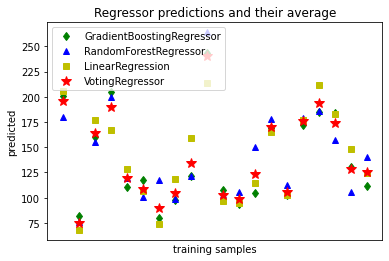

In [47]:
#COPYPASTA
plt.figure()
plt.plot(pred1, "gd", label="GradientBoostingRegressor")
plt.plot(pred2, "b^", label="RandomForestRegressor")
plt.plot(pred3, "ys", label="LinearRegression")
plt.plot(pred4, "r*", ms=10, label="VotingRegressor")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Regressor predictions and their average")

plt.show()

### 1.1.8 Stacked generalization

**Stacked generalization** is a method for combining estimators to reduce their biases. The predictions of each individual estimator are stacked together and used as input to a final estimator, which is trained through cross-validation. The `estimators` parameter corresponds to the list of estimators which are stacked together in parallel on the input data, and `final_estimator` will use those as inputs

Example:

In [60]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score

In [61]:
estimators = [('ridge', RidgeCV()), 
              ('lasso', LassoCV(random_state=42)), 
              ('knr', KNeighborsRegressor(n_neighbors=20,metric='euclidean'))]

In [62]:
final_estimator = GradientBoostingRegressor(n_estimators=25, subsample=0.5,
                                           min_samples_leaf=25, max_features=1,
                                           random_state=42)

reg = StackingRegressor(estimators=estimators, final_estimator=final_estimator)

In [63]:
X, y = load_diabetes(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

reg.fit(X_train, y_train)

StackingRegressor(estimators=[('ridge',
                               RidgeCV(alphas=array([ 0.1,  1. , 10. ]))),
                              ('lasso', LassoCV(random_state=42)),
                              ('knr',
                               KNeighborsRegressor(metric='euclidean',
                                                   n_neighbors=20))],
                  final_estimator=GradientBoostingRegressor(max_features=1,
                                                            min_samples_leaf=25,
                                                            n_estimators=25,
                                                            random_state=42,
                                                            subsample=0.5))

In [64]:
y_pred = reg.predict(X_test)

print(f"R2 score: {r2_score(y_test,y_pred)}")

R2 score: 0.5267013426135393


In [65]:
#you can also get output of the stacked estimators with the .transform() method
reg.transform(X_test[:5])

array([[142.36214074, 138.30765507, 146.1       ],
       [179.70207217, 182.90046333, 151.75      ],
       [139.89924327, 132.47007083, 158.25      ],
       [286.94742491, 292.65164781, 225.4       ],
       [126.88190192, 124.11964797, 164.65      ]])

In [67]:
final_layer_rfr = RandomForestRegressor(n_estimators=10, max_features=1,
                                       max_leaf_nodes=5, random_state=42)

final_layer_gbr = GradientBoostingRegressor(n_estimators=10, max_features=1,
                                       max_leaf_nodes=5, random_state=42)

final_layer = StackingRegressor(estimators=[('rf', final_layer_rfr),
                                            ('gbrt', final_layer_gbr)], 
                                final_estimator=RidgeCV())

multi_layer_regressor = StackingRegressor(estimators=[('ridge', RidgeCV()), 
                                            ('lasso', LassoCV(random_state=42)), 
                                            ('knr', KNeighborsRegressor(
                                                n_neighbors=20,
                                                metric='euclidean'))])

In [68]:
multi_layer_regressor.fit(X_train, y_train)

StackingRegressor(estimators=[('ridge',
                               RidgeCV(alphas=array([ 0.1,  1. , 10. ]))),
                              ('lasso', LassoCV(random_state=42)),
                              ('knr',
                               KNeighborsRegressor(metric='euclidean',
                                                   n_neighbors=20))])

In [69]:
print(f"R2 score: {multi_layer_regressor.score(X_test, y_test)}")

R2 score: 0.5013793766070471
